# Task-dependent EC with MOU and DCM


### Reshape EC-MOU:

In [22]:
import os
import os.path
import numpy as np
import scipy.linalg as spl
from scipy import stats
import scipy.io as sio
import matplotlib.pyplot as plt



model = 'PCB2016'
#model = 'NeNe2020'
model = 'new_2021' 
#model = 'pos2021' 


# Optimization parameters
min_C     =  -1
max_C     =   1
eta_C     =   0.01
eta_Sigma =   0.05
eta_tau   =   0.1
max_iter  =   1000

n_sub    = 157 #150
delta_TR = 2 # time shift

# Model
n_cond   = 3
n_sess   = 10
n_rois   = 24
TR       = 1

# Index dictionary
conf = {
        'tasks'   : ['vfm','movie','rest'], 
        'eccen'   : ['fovea','para-fovea'], 
        'fovea'   : [ 
                    [0,2,4,6,8,10,12,14,16,18,20,22],  #  < fovea
                    [1,3,5,7,9,11,13,15,17,19,21,23],   #  > fovea
                    ],
        'roiname' : ['V1','V2','V3'], 
        'rois'    : [
                    [0,1,2,3,12,13,14,15],   # V1
                    [4,5,6,7,16,17,18,19],   # V2
                    [8,9,10,11,20,21,22,23]  # V3
                    ],
        'task'    : [
                    [0,1],     # retinotopy
                    [2,3,4,5], # movie watching
                    [6,7,8,9]  # resting state
                    ],

        'hemis'   : ['left', 'right'],
        'flows'   : ['outflow', 'inflow']
        }


# Time series 
# ---------------------------------------------------------------------------------------------------------------------------

task_ID_1  = ['tfMRI_RETBAR1_7T_AP',
              'tfMRI_RETBAR2_7T_PA'
              ]

task_ID_2  = ['tfMRI_MOVIE1_7T_AP',
              'tfMRI_MOVIE2_7T_PA',
              'tfMRI_MOVIE3_7T_PA',
              'tfMRI_MOVIE4_7T_AP', 
             ]

task_ID_3  = ['rfMRI_REST1_7T_PA',
              'rfMRI_REST2_7T_AP',
              'rfMRI_REST3_7T_PA',
              'rfMRI_REST4_7T_AP'
             ]

task_ID = task_ID_1 + task_ID_2 + task_ID_3
fileobj     = open('/home/nicolas/Documents/RetNet/retNet_analyses/HCP_7T_prep/subj_id.txt')
data        = fileobj.read()
subject_ID  = data.split('\n')

# Subjects x Task
scans    = [i for i in range(n_sub*10)]
scan_idx = np.zeros((10,n_sub)).astype(np.uint)
for n in range(10):
    scan = [x for x in scans if x%10 ==n]
    scan_idx[n,:] = scan
print('Subjects x Task : \n', scan_idx)


prep_pth = '/home/nicolas/Documents/RetNet/ret-EC/'
#time_series = {'data': data, 'scan_idx': scan_idx}
fname = os.path.join(prep_pth + 'tseries_24rois_allsubjects.npy')
time_series = np.load(fname,allow_pickle=True).item()
data = time_series['data']
scan_idx = time_series['scan_idx']
print(scan_idx.shape)
#tSeries = data[scan_idx[:,:]]

#sio.savemat(prep_pth + 'HCP_ecv24rois.mat', {'data': tSeries, 'scan_idx': scan_idx})

pth         = '/home/nicolas/Documents/RetNet/ret-EC/new_results/'

# Directory containing the .npy files
directory = pth

# Define the conditions and the corresponding filenames
conditions = conf['tasks']
model = 'new_2021'  # Replace with your actual model name

# Initialize lists to store the loaded data
model_fit_list = []
model_error_list = []
J_mod_list = []
EC_normed_list = []
Sigma_mod_list = []
tau_x_list = []
tau_list = []

# Load the files for each condition
for cond in conditions:
    appendix = model + '_' + cond
    model_fit = np.load(os.path.join(directory, 'Fit' + appendix + '.npy'))
    model_error = np.load(os.path.join(directory, 'Error' + appendix + '.npy'))
    J_mod = np.load(os.path.join(directory, 'J_mod' + appendix + '.npy'))
    EC_normed = np.load(os.path.join(directory, 'EC_normed' + appendix + '.npy'))
    Sigma_mod = np.load(os.path.join(directory, 'Sigma_mod' + appendix + '.npy'))
    tau_x = np.load(os.path.join(directory, 'Tau_rois' + appendix + '.npy'))
    tau = np.load(os.path.join(directory, 'Tau_mean' + appendix + '.npy'))
    
    # Append to lists
    model_fit_list.append(model_fit)
    model_error_list.append(model_error)
    J_mod_list.append(J_mod)
    EC_normed_list.append(EC_normed)
    Sigma_mod_list.append(Sigma_mod)
    tau_x_list.append(tau_x)
    tau_list.append(tau)

# Convert lists to NumPy arrays if needed
model_fit_array = np.array(model_fit_list)
model_error_array = np.array(model_error_list)
J_mod_array = np.array(J_mod_list)
EC_normed_array = np.array(EC_normed_list)
Sigma_mod_array = np.array(Sigma_mod_list)
tau_x_array = np.array(tau_x_list)
tau_array = np.array(tau_list)

# Print the loaded data shapes for verification
for i, cond in enumerate(conditions):
    print(f"Condition: {cond}")
    print(f"  Fit shape: {model_fit_array[i].shape}")
    print(f"  Error shape: {model_error_array[i].shape}")
    print(f"  J_mod shape: {J_mod_array[i].shape}")
    print(f"  EC_normed shape: {EC_normed_array[i].shape}")
    print(f"  Sigma_mod shape: {Sigma_mod_array[i].shape}")
    print(f"  Tau_rois shape: {tau_x_array[i].shape}")
    print(f"  Tau_mean shape: {tau_array[i].shape}")

    nan_indices = np.argwhere(np.isnan(EC_normed))

#print(nan_indices)
# Extract unique subject indices (assuming the first dimension is the subject index)
subject_indices_with_nans = np.unique(nan_indices[0])

print("Subject indices with NaNs:", subject_indices_with_nans)

# Subject index to be removed
subject_index_to_remove = 114

# Remove the subject's data
EC_normed = np.delete(EC_normed, subject_index_to_remove, axis=1)

# Squeeze out any singleton dimensions if necessary
EC_mou = np.squeeze(EC_normed)

print("Shape after removing subject:", EC_normed.shape)

Subjects x Task : 
 [[   0   10   20 ... 1540 1550 1560]
 [   1   11   21 ... 1541 1551 1561]
 [   2   12   22 ... 1542 1552 1562]
 ...
 [   7   17   27 ... 1547 1557 1567]
 [   8   18   28 ... 1548 1558 1568]
 [   9   19   29 ... 1549 1559 1569]]
(10, 157)
Condition: vfm
  Fit shape: (3, 157)
  Error shape: (3, 157)
  J_mod shape: (3, 157, 24, 24)
  EC_normed shape: (3, 157, 24, 24)
  Sigma_mod shape: (3, 157, 24, 24)
  Tau_rois shape: (157, 3, 24)
  Tau_mean shape: ()
Condition: movie
  Fit shape: (3, 157)
  Error shape: (3, 157)
  J_mod shape: (3, 157, 24, 24)
  EC_normed shape: (3, 157, 24, 24)
  Sigma_mod shape: (3, 157, 24, 24)
  Tau_rois shape: (157, 3, 24)
  Tau_mean shape: ()
Condition: rest
  Fit shape: (3, 157)
  Error shape: (3, 157)
  J_mod shape: (3, 157, 24, 24)
  EC_normed shape: (3, 157, 24, 24)
  Sigma_mod shape: (3, 157, 24, 24)
  Tau_rois shape: (157, 3, 24)
  Tau_mean shape: ()
Subject indices with NaNs: [  0 114]
Shape after removing subject: (3, 156, 24, 24)


In [27]:
X_mou = EC_normed.reshape((3*156,24*24))
y = np.repeat(np.arange(3).reshape(3,1),156,axis=1).reshape((3*156))

print(np.repeat(np.arange(3).reshape(3,1),4,axis=1))

print('X mou : ', X_mou.shape)

[[0 0 0 0]
 [1 1 1 1]
 [2 2 2 2]]
X mou :  (468, 576)


### Reshape EC-rDCM: 

In [ ]:
# Define the path and appendix
pth = "/home/nicolas/Documents/RetNet/ret-EC/new_results/"
appendix = "rDCM"

EC_dcm = np.load(os.path.join(directory, 'EC_normed' + appendix + '.npy'))
S_dcm = np.load(os.path.join(directory, 'S_dcm' + appendix + '.npy'))

print('EC shape : ', EC_dcm.shape, '\nS shape :', S_dcm.shape )
print(conf['task'][0])

EC_vfm = np.mean(EC_dcm[conf['task'][0],:,:],axis=0)


EC = np.zeros((3,156,24,24))
for i_cond in range(n_cond):
    EC[i_cond,:,:,:] = np.mean(EC_dcm[conf['task'][i_cond],:,:],axis=0)

X_dcm = EC.reshape((3*156,24*24))

print('X shape : ', X_dcm.shape)

EC shape :  (10, 156, 24, 24) 
S shape : (10, 156, 24)
[0, 1]
(156, 24, 24)


## Compare linear and non-linear classifiers

> check https://etulab.univ-amu.fr/gilson.m/compneuro_course/-/blob/main/sup_lrn/nb3_compare_classifiers.ipynb?ref_type=heads for details

In [29]:
# import librairies

import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV

# classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix

import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb

font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 18}
mpl.rc('font', **font)

In [62]:
# classifiers
clf_MLR = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=500)

clf_SGD = SGDClassifier(loss='log_loss', penalty='l2', max_iter=500)

clf_1NN = KNeighborsClassifier(n_neighbors=1, algorithm='brute', metric='minkowski')

clf_RF = RandomForestClassifier(n_estimators=10)

clf_QDA = QuadraticDiscriminantAnalysis()

dict_clf = {'MLR': clf_MLR,
 #           'SGD': clf_SGD,
            '1NN': clf_1NN,
#            'QDA': clf_QDA,
            'RF': clf_RF}

# dictionary of hyperparameters and ranges to explore (grid search)
dict_params = {'C': [0.01,0.1,1.0,10.0,100.0],               # C for regularization
#               'alpha': [0.001,0.01,0.1,1.0,10.0],           # alpha for regularization
               'n_neighbors': [1,2,3,4,5],              # splitting quality eval
#               'reg_param': [0.01,0.1,1.0]   ,               # k nearest neighbors
               'criterion': ['gini', 'entropy']}                  # regularization param

In [63]:
# outer cross-validation scheme: 80% for training and 20% for testing
cvs = StratifiedShuffleSplit(n_splits=50, test_size=0.2)

 # nested cross-validation scheme
n_split_nest = 5
cv_nest = StratifiedKFold(n_splits=n_split_nest)

## MOU

In [64]:
X = X_mou
# to store result accuracies
acc = pd.DataFrame()
CM = np.zeros((3,3))

# loop over classifiers
for i, (k, param_name) in enumerate(zip(dict_clf,dict_params)):
    # get classifier and related information
    clf = dict_clf[k]
    param_vals = dict_params[param_name]
    # print(param_name, param_vals)

    # repeat classification
    for train_ind, test_ind in cvs.split(X, y):
        # grid search for hyperparameter C
        gscv = GridSearchCV(clf,
                    {param_name: param_vals},
                    cv=cv_nest)
        gscv.fit(X[train_ind,:], y[train_ind])
        best_clf = gscv.best_estimator_
        print(gscv.best_params_)

        # train and test best classifier with subject labels
        best_clf.fit(X[train_ind,:], y[train_ind])
        # train and test accuracies
        d = {'type': ['train'],
             'clf': [k], 
             'score': [best_clf.score(X[train_ind,:], y[train_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)
        d = {'type': ['test'],
             'clf': [k], 
             'score': [best_clf.score(X[test_ind,:], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

        CM += confusion_matrix(y[test_ind], best_clf.predict(X[test_ind,:]))

        # shuffling labels and fit again for evaluation of chance level
        train_ind_rand = np.random.permutation(train_ind)
        best_clf.fit(X[train_ind,:], y[train_ind_rand])
        d = {'type': ['shuf'],
             'clf': [k], 
             'score': [best_clf.score(X[test_ind,:], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

        
# print table of results
print()
print(acc)

{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'C': 100.0}
{'n_neighbors': 2}
{'n_neighbors': 5}
{'n_neighbors': 4}
{'n_neighbors': 5}
{'n_neighbors': 3}
{'n_neighbors': 3}
{'n_neighbors': 5}
{'n_neighbors': 3}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 3}
{'n_neighbors': 5}
{'n_neighbors': 4}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 3}
{'n_neighbors': 3}
{'n_neighbors': 5}
{'n_neig

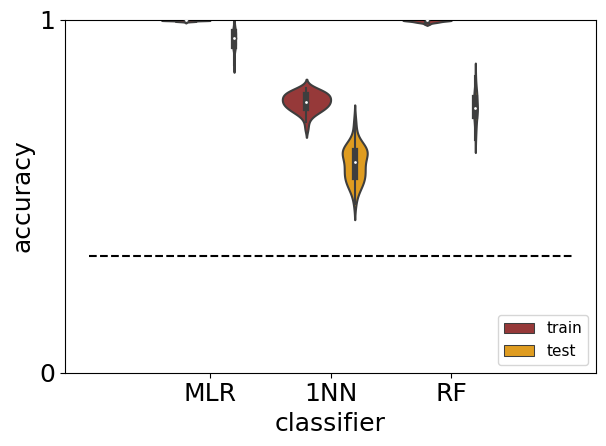

In [69]:
# plot: train versus test accuracy
acc2 = acc[np.logical_or(acc['type']=='train',acc['type']=='test')]

# theoretical chance level
chance_level = 0.33

sb.violinplot(data=acc2, x='clf', y='score', hue='type',
              density_norm='width', palette=['brown','orange'])
plt.plot([-1,3], [chance_level]*2, '--k')
plt.yticks([0,1])
plt.xlabel('classifier')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.legend(loc='lower right', fontsize=11)
plt.tight_layout()
plt.show()

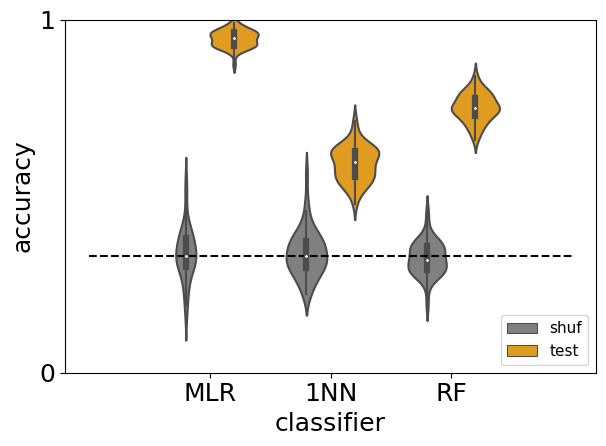

In [68]:
 # test versus baseline accuracy
acc2 = acc[np.logical_or(acc['type']=='shuf',acc['type']=='test')]

sb.violinplot(data=acc2, x='clf', y='score', hue='type', hue_order=['shuf','test'], 
              density_norm='width', palette=['gray','orange'])
plt.plot([-1,3], [chance_level]*2, '--k')
plt.yticks([0,1])
plt.xlabel('classifier')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.legend(loc='lower right', fontsize=11)
plt.tight_layout()
plt.show()

([<matplotlib.axis.YTick at 0x7b67741b4b20>,
 [Text(0, 0, 'vfm'), Text(0, 1, 'movie'), Text(0, 2, 'rest')])

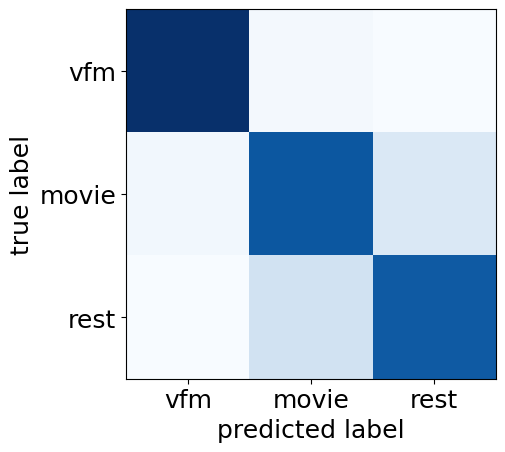

In [56]:
plt.imshow(CM, cmap='Blues', interpolation='nearest')
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.xticks(range(3), ['vfm','movie','rest'])
plt.yticks(range(3), ['vfm','movie','rest'])

## rDCM

In [70]:
X = X_dcm
# to store result accuracies
acc = pd.DataFrame()
CM = np.zeros((3,3))

# loop over classifiers
for i, (k, param_name) in enumerate(zip(dict_clf,dict_params)):
    # get classifier and related information
    clf = dict_clf[k]
    param_vals = dict_params[param_name]
    # print(param_name, param_vals)

    # repeat classification
    for train_ind, test_ind in cvs.split(X, y):
        # grid search for hyperparameter C
        gscv = GridSearchCV(clf,
                    {param_name: param_vals},
                    cv=cv_nest)
        gscv.fit(X[train_ind,:], y[train_ind])
        best_clf = gscv.best_estimator_
        print(gscv.best_params_)

        # train and test best classifier with subject labels
        best_clf.fit(X[train_ind,:], y[train_ind])
        # train and test accuracies
        d = {'type': ['train'],
             'clf': [k], 
             'score': [best_clf.score(X[train_ind,:], y[train_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)
        d = {'type': ['test'],
             'clf': [k], 
             'score': [best_clf.score(X[test_ind,:], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

        CM += confusion_matrix(y[test_ind], best_clf.predict(X[test_ind,:]))

        # shuffling labels and fit again for evaluation of chance level
        train_ind_rand = np.random.permutation(train_ind)
        best_clf.fit(X[train_ind,:], y[train_ind_rand])
        d = {'type': ['shuf'],
             'clf': [k], 
             'score': [best_clf.score(X[test_ind,:], y[test_ind])]}
        acc = pd.concat((acc, pd.DataFrame(data=d)), ignore_index=True)

        
# print table of results
print()
print(acc)

{'C': 0.01}
{'C': 10.0}
{'C': 10.0}
{'C': 0.1}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 0.1}
{'C': 0.01}
{'C': 0.01}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 0.01}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 0.01}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 0.01}
{'C': 0.1}
{'C': 0.1}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 0.01}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'C': 0.01}
{'C': 10.0}
{'C': 10.0}
{'C': 10.0}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_neighbors': 5}
{'n_n

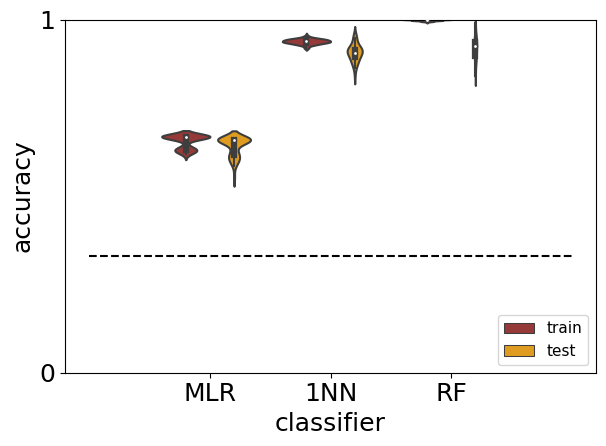

In [72]:
# plot: train versus test accuracy
acc2 = acc[np.logical_or(acc['type']=='train',acc['type']=='test')]

# theoretical chance level
chance_level = 0.33

sb.violinplot(data=acc2, x='clf', y='score', hue='type',
              density_norm='width', palette=['brown','orange'])
plt.plot([-1,3], [chance_level]*2, '--k')
plt.yticks([0,1])
plt.xlabel('classifier')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.legend(loc='lower right', fontsize=11)
plt.tight_layout()
plt.show()


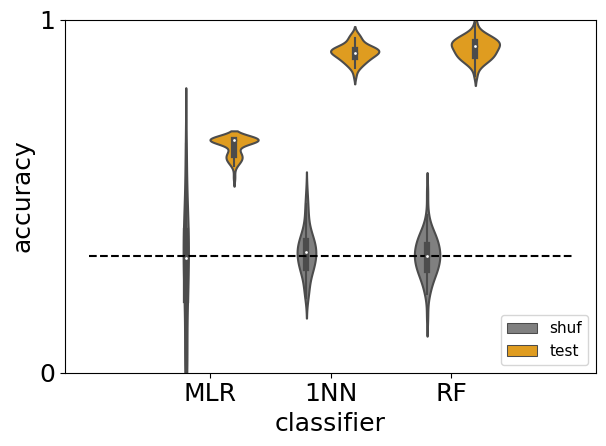

In [73]:
 # test versus baseline accuracy
acc2 = acc[np.logical_or(acc['type']=='shuf',acc['type']=='test')]

sb.violinplot(data=acc2, x='clf', y='score', hue='type', hue_order=['shuf','test'], 
              density_norm='width', palette=['gray','orange'])
plt.plot([-1,3], [chance_level]*2, '--k')
plt.yticks([0,1])
plt.xlabel('classifier')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.legend(loc='lower right', fontsize=11)
plt.tight_layout()
plt.show()

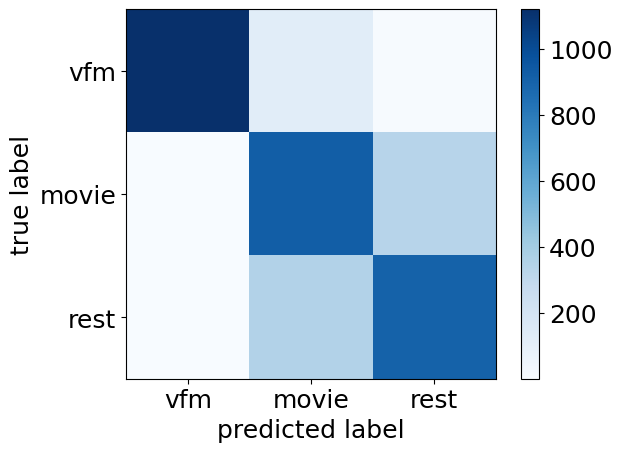

In [61]:
plt.imshow(CM, cmap='Blues', interpolation='nearest')
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.xticks(range(3), ['vfm','movie','rest'])
plt.yticks(range(3), ['vfm','movie','rest'])
plt.colorbar()

## Alignment between MOU and rDCM

Text(0.5, 1.0, 'PearsonRResult(statistic=0.6400787797951755, pvalue=0.0)')

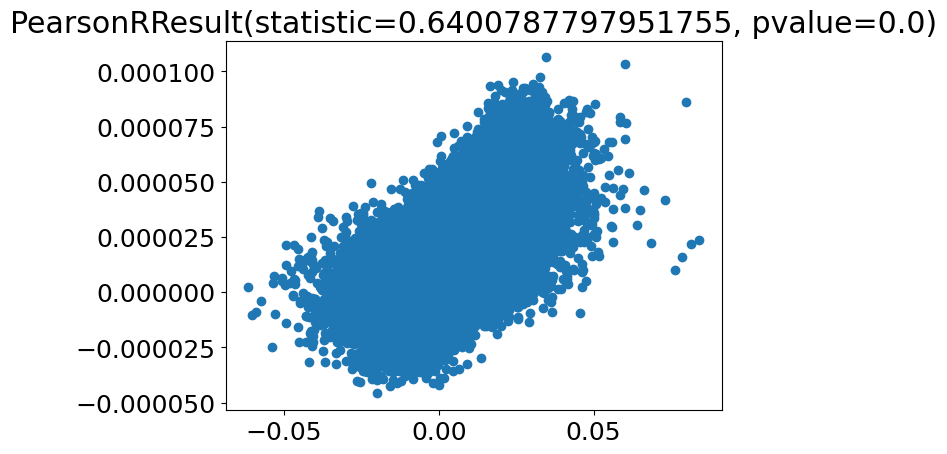

In [81]:
import scipy.stats as stt 
plt.scatter(EC_mou.flatten(), X_dcm.flatten())
plt.title(stt.pearsonr(EC_mou.flatten(), X_dcm.flatten()))
#plt.title(stt.spearmanr(EC_mou.flatten(), X_dcm.flatten()))